In [19]:
# ==============================================================
# SENTIMENT ANALYSIS USING NAÏVE BAYES (Twitter Dataset)
# ==============================================================

# STEP 1: Import libraries
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [21]:
# --------------------------------------------------------------
# STEP 2: Load Dataset
# --------------------------------------------------------------
df = pd.read_csv("dataset.csv")   # replace with actual filename
print("Dataset Shape:", df.shape)
print("\nDataset Preview:")
print(df.head())

Dataset Shape: (74681, 4)

Dataset Preview:
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     


In [23]:
df.columns = ["record_id", "entity", "sentiment", "text"]
df.head()

,record_id,entity,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [37]:
# --------------------------------------------------------------
# STEP 3: Keep only sentiment + text
# --------------------------------------------------------------
df = df[['sentiment', 'text']]
print(df.head())
df.info()

  sentiment                                               text
0  Positive  I am coming to the borders and I will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...
3  Positive  im getting on borderlands 2 and i will murder ...
4  Positive  im getting into borderlands and i can murder y...
<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  73995 non-null  object
 1   text       73995 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [39]:
df.isnull().values.any()
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [41]:
df.dropna(inplace=True)
print("\nUnique Sentiments:", df['sentiment'].unique())


Unique Sentiments: ['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [43]:
# --------------------------------------------------------------
# STEP 4: Data Cleaning
# --------------------------------------------------------------
def clean_text(text):
    text = str(text).lower()                           # lowercase
    text = re.sub(r"http\S+", "", text)                # remove URLs
    text = re.sub(r"@\w+", "", text)                   # remove @mentions
    text = re.sub(r"#\w+", "", text)                   # remove hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)                    # remove numbers
    text = re.sub(r"\s+", " ", text).strip()           # remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)

print("\nSample cleaned tweets:")
print(df[['text', 'clean_text']].head())


Sample cleaned tweets:
                                                text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                          clean_text  
0  i am coming to the borders and i will kill you...  
1  im getting on borderlands and i will kill you all  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands and i will murder yo...  
4  im getting into borderlands and i can murder y...  


In [45]:
# --------------------------------------------------------------
# STEP 5: Encode Sentiment Labels
# --------------------------------------------------------------
df['sentiment'] = df['sentiment'].map({
    "Positive": "positive",
    "Negative": "negative",
    "Neutral": "neutral",
    "Irrelevant": "irrelevant"
})

# Verify class distribution
print("\nClass distribution:")
print(df['sentiment'].value_counts())


Class distribution:
sentiment
negative      22358
positive      20654
neutral       18108
irrelevant    12875
Name: count, dtype: int64


C:\Users\Sumit\AppData\Local\Temp\ipykernel_29516\1250416283.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette="Set2")


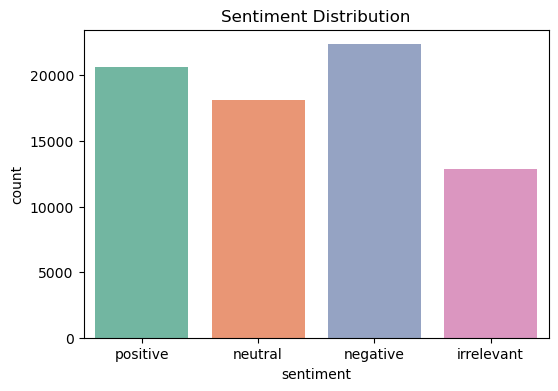

WordCloud not installed, skipping visualization.


In [47]:
# --------------------------------------------------------------
# STEP 6: Data Visualization
# --------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'], palette="Set2")
plt.title("Sentiment Distribution")
plt.show()

# Word cloud (optional if you have wordcloud library installed)
try:
    from wordcloud import WordCloud
    text_all = " ".join(df['clean_text'])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Tweets")
    plt.show()
except:
    print("WordCloud not installed, skipping visualization.")

In [49]:
# --------------------------------------------------------------
# STEP 7: Split Data
# --------------------------------------------------------------
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Samples:", len(X_train))
print("Testing Samples:", len(X_test))


Training Samples: 59196
Testing Samples: 14799


In [51]:
# --------------------------------------------------------------
# STEP 8: Vectorization
# --------------------------------------------------------------
# Option 1: TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Option 2: Bag of Words (for comparison)
bow_vectorizer = CountVectorizer(stop_words="english", max_features=5000, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("\nVectorization complete. TF-IDF shape:", X_train_vec.shape)


Vectorization complete. TF-IDF shape: (59196, 5000)


In [53]:
# --------------------------------------------------------------
# STEP 9: Train Models
# --------------------------------------------------------------
# Model 1: Multinomial Naïve Bayes (works best for word counts/TF-IDF)
mnb_model = MultinomialNB()
mnb_model.fit(X_train_vec, y_train)

# Model 2: Bernoulli Naïve Bayes (works well with binary word presence)
bnb_model = BernoulliNB()
bnb_model.fit(X_train_bow, y_train)

BernoulliNB()


MultinomialNB Accuracy: 0.633623893506318

MultinomialNB Report:
               precision    recall  f1-score   support

  irrelevant       0.71      0.36      0.48      2575
    negative       0.62      0.80      0.70      4472
     neutral       0.66      0.52      0.58      3621
    positive       0.62      0.73      0.67      4131

    accuracy                           0.63     14799
   macro avg       0.65      0.60      0.60     14799
weighted avg       0.64      0.63      0.62     14799


BernoulliNB Accuracy: 0.6240962227177512

BernoulliNB Report:
               precision    recall  f1-score   support

  irrelevant       0.59      0.47      0.53      2575
    negative       0.69      0.70      0.69      4472
     neutral       0.68      0.46      0.55      3621
    positive       0.56      0.78      0.65      4131

    accuracy                           0.62     14799
   macro avg       0.63      0.60      0.61     14799
weighted avg       0.63      0.62      0.62     14799


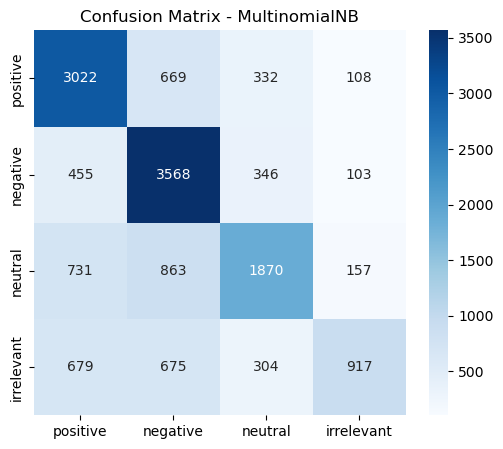

In [55]:
# --------------------------------------------------------------
# STEP 10: Evaluate Models
# --------------------------------------------------------------
# Evaluate MNB
y_pred_mnb = mnb_model.predict(X_test_vec)
print("\nMultinomialNB Accuracy:", accuracy_score(y_test, y_pred_mnb))
print("\nMultinomialNB Report:\n", classification_report(y_test, y_pred_mnb))

# Evaluate BNB
y_pred_bnb = bnb_model.predict(X_test_bow)
print("\nBernoulliNB Accuracy:", accuracy_score(y_test, y_pred_bnb))
print("\nBernoulliNB Report:\n", classification_report(y_test, y_pred_bnb))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_mnb, labels=["positive", "negative", "neutral", "irrelevant"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive","negative","neutral","irrelevant"],
            yticklabels=["positive","negative","neutral","irrelevant"])
plt.title("Confusion Matrix - MultinomialNB")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --------------------------------------------------------------
# STEP 10.1: Detailed Metrics for MNB
# --------------------------------------------------------------
accuracy = accuracy_score(y_test, y_pred_mnb)
precision = precision_score(y_test, y_pred_mnb, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_mnb, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_mnb, average='weighted', zero_division=0)

print("\n🔹 Detailed Metrics (MultinomialNB):")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# --------------------------------------------------------------
# STEP 10.2: Per-Class Metrics
# --------------------------------------------------------------
print("\n🔹 Per-Class Metrics (MultinomialNB):")
print(classification_report(y_test, y_pred_mnb, zero_division=0))

# --------------------------------------------------------------
# STEP 10.3: Correlation Matrix of Features
# --------------------------------------------------------------
# Correlation of TF-IDF features (dense form might be huge, so limit to small sample)
X_dense = pd.DataFrame(X_train_vec.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
corr_matrix = X_dense.corr()

# Show only top 20 features correlation for readability
sample_corr = corr_matrix.iloc[:20, :20]

plt.figure(figsize=(12,10))
sns.heatmap(sample_corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of TF-IDF Features (Sample 20x20)")
plt.show()

# --------------------------------------------------------------
# STEP 10.4: Confusion Matrix with Normalized Percentages
# --------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred_mnb, labels=["positive","negative","neutral","irrelevant"])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=["positive","negative","neutral","irrelevant"],
            yticklabels=["positive","negative","neutral","irrelevant"])
plt.title("Normalized Confusion Matrix - MultinomialNB")
plt.show()



🔹 Detailed Metrics (MultinomialNB):
Accuracy  : 0.6336
Precision : 0.6439
Recall    : 0.6336
F1 Score  : 0.6216

🔹 Per-Class Metrics (MultinomialNB):
              precision    recall  f1-score   support

  irrelevant       0.71      0.36      0.48      2575
    negative       0.62      0.80      0.70      4472
     neutral       0.66      0.52      0.58      3621
    positive       0.62      0.73      0.67      4131

    accuracy                           0.63     14799
   macro avg       0.65      0.60      0.60     14799
weighted avg       0.64      0.63      0.62     14799



In [57]:
# --------------------------------------------------------------
# STEP 11: Cross-Validation (to check stability)
# --------------------------------------------------------------
scores = cross_val_score(mnb_model, X_train_vec, y_train, cv=5)
print("\nCross-validation scores (MNB):", scores)
print("Mean CV Accuracy:", np.mean(scores))

# --------------------------------------------------------------
# STEP 12: Test with Custom Inputs
# --------------------------------------------------------------
test_sentences = [
    "I love playing Borderlands, it’s amazing!",
    "This game is the worst thing ever.",
    "Not bad, just okay.",
    "What are you even talking about?"
]

test_vec = tfidf_vectorizer.transform(test_sentences)
predictions = mnb_model.predict(test_vec)

print("\nCustom Test Predictions:")
for text, label in zip(test_sentences, predictions):
    print(f"Text: {text} -> Predicted Sentiment: {label}")


Cross-validation scores (MNB): [0.62111486 0.62395473 0.62860039 0.62648872 0.62522172]
Mean CV Accuracy: 0.625076085566942

Custom Test Predictions:
Text: I love playing Borderlands, it’s amazing! -> Predicted Sentiment: positive
Text: This game is the worst thing ever. -> Predicted Sentiment: negative
Text: Not bad, just okay. -> Predicted Sentiment: negative
Text: What are you even talking about? -> Predicted Sentiment: negative


In [59]:
# --------------------------------------------------------------
# STEP 13: Save Model & Vectorizer
# --------------------------------------------------------------
joblib.dump(mnb_model, "sentiment_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

print("\n✅ Model and Vectorizer saved as 'sentiment_model.pkl' and 'tfidf_vectorizer.pkl'")


✅ Model and Vectorizer saved as 'sentiment_model.pkl' and 'tfidf_vectorizer.pkl'
